# Data Analysis - BTCUSDT Trading Strategy Creation

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import norm

Upload BTCUSDT data extracted from Bybit

In [2]:
coin_df = pd.read_csv("BTCUSDT 5.csv").iloc[:, 3:].set_index('datetime')
coin_df

,open,high,low,close
datetime,,,,
2020-02-17 11:25:00,9632.88,9658.14,9629.56,9658.14
2020-02-17 11:30:00,9658.14,9701.11,9658.06,9659.92
2020-02-17 11:35:00,9659.92,9664.66,9616.40,9616.46
2020-02-17 11:40:00,9616.46,9627.83,9588.07,9604.98
2020-02-17 11:45:00,9604.98,9620.65,9583.22,9620.37
...,...,...,...,...
2022-09-16 17:40:00,19460.84,19484.41,19450.78,19479.94
2022-09-16 17:45:00,19479.94,19490.77,19435.15,19469.50
2022-09-16 17:50:00,19469.50,19480.26,19444.24,19452.83


## Candles Analysis
I extrapolate the Profit & Loss Percentage of every single candle to try to extract useful data for the design of a trading strategy (as the calculation of the Stop Loss)

In [3]:
coin_df['candle'] = np.where(coin_df['close'] > coin_df['open'], 1, 0)
coin_df['pnl'] = coin_df['close'] - coin_df['open']
coin_df['pnl %'] = coin_df['pnl']/coin_df['open']

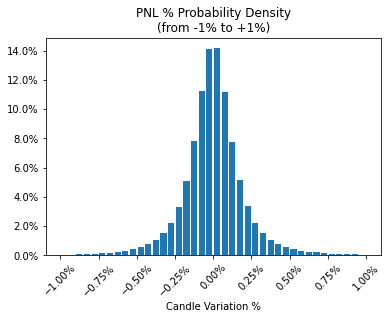

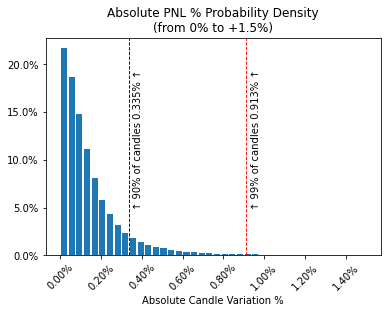

Mean: 5.97e-06
 STD: 0.00258907

80,0% of PNL % is between -0.00333 and 0.00224
90,0% of PNL % is between -0.00222 and 0.00336
99,0% of PNL % is between -0.00908 and 0.00918
99,9% of PNL % is between -0.02077 and 0.02103


In [4]:
# Plot the histogram of the pnl%
plt.hist(coin_df['pnl %'], bins = 40, range = (-0.01, 0.01), rwidth = 0.8,
         weights=np.ones_like(coin_df['pnl %']) / len(coin_df['pnl %']))

plt.title("PNL % Probability Density\n(from -1% to +1%)")
plt.xlabel("Candle Variation %")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xticks(rotation = 45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()


# Plot the histogram of the absolute pnl%
plt.hist(coin_df['pnl %'].abs(), bins = 40, range = (0, 0.015), rwidth = 0.8,
         weights=np.ones_like(coin_df['pnl %']) / len(coin_df['pnl %']))

perc_90 = np.percentile(coin_df['pnl %'].abs(), 90)
perc_99 = np.percentile(coin_df['pnl %'].abs(), 99)
plt.axvline(x = perc_90, color = 'black', linestyle = '--', linewidth = 0.9)
plt.text(perc_90*1.06, 0.05, f"↑ 90% of candles {round(perc_90*100, 3)}% ↑", rotation = 90)
plt.axvline(x = perc_99, color = 'red', linestyle = '--', linewidth = 0.9)
plt.text(perc_99*1.025, 0.05, f"↑ 99% of candles {round(perc_99*100, 3)}% ↑", rotation = 90)

plt.title("Absolute PNL % Probability Density\n(from 0% to +1.5%)")
plt.xlabel("Absolute Candle Variation %")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.xticks(rotation = 45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()
plt.show()

# Print the most important data: Mean, STD and percentiles
print(f"Mean: {round(coin_df['pnl %'].mean(), 8)}\n STD: {round(coin_df['pnl %'].std(), 8)}\n")

print(f"80,0% of PNL % is between {round(np.percentile(coin_df['pnl %'], 5), 5)} and {round(np.percentile(coin_df['pnl %'], 90), 5)}")
print(f"90,0% of PNL % is between {round(np.percentile(coin_df['pnl %'], 10), 5)} and {round(np.percentile(coin_df['pnl %'], 95), 5)}")
print(f"99,0% of PNL % is between {round(np.percentile(coin_df['pnl %'], 0.5), 5)} and {round(np.percentile(coin_df['pnl %'], 99.5), 5)}")
print(f"99,9% of PNL % is between {round(np.percentile(coin_df['pnl %'], 0.05), 5)} and {round(np.percentile(coin_df['pnl %'], 99.95), 5)}")

As we can see 90% of the candles have a variation of less than 0.25% and the 99% of the candles have a variation of almost 1%. The market is fairly balanced, so let's move on to another type of analysis.

## SMA & EMA Analysis
Let's start by analyzing the relationship between the price and different SMAs and EMAs. Now calculate SMA & EMA values for all the dataset.

In [5]:
from ta.trend import SMAIndicator
from ta.trend import EMAIndicator

# Extract SMA & EMA values
coin_df['SMA 6'] = SMAIndicator(coin_df['close'], 6).sma_indicator() # 30 Minutes
coin_df['SMA 12'] = SMAIndicator(coin_df['close'], 12).sma_indicator() # 1 Hour
coin_df['SMA 36'] = SMAIndicator(coin_df['close'], 36).sma_indicator() # 3 Hour
coin_df['SMA 72'] = SMAIndicator(coin_df['close'], 72).sma_indicator() # 6 Hour
coin_df['SMA 144'] = SMAIndicator(coin_df['close'], 144).sma_indicator() # 12 Hour

coin_df['EMA 6'] = EMAIndicator(coin_df['close'], 6).ema_indicator() # 30 Minutes
coin_df['EMA 12'] = EMAIndicator(coin_df['close'], 12).ema_indicator() # 1 Hour
coin_df['EMA 36'] = EMAIndicator(coin_df['close'], 36).ema_indicator() # 3 Hour
coin_df['EMA 72'] = EMAIndicator(coin_df['close'], 72).ema_indicator() # 6 Hour
coin_df['EMA 144'] = EMAIndicator(coin_df['close'], 144).ema_indicator() # 12 Hour

Then we want verify the correlation between the position of the open price relative to the MA shifted by 1.

In [6]:
ma_proba = {}

def candle_position_freq(ma):
    ret_dict = {}
    
    above_ma = coin_df['open'] > ma.shift(1)
    below_ma = coin_df['open'] < ma.shift(1)
    
    ret_dict['Above & Buy'] = \
        coin_df.loc[(coin_df['close'] > coin_df['open']) & (above_ma)].shape[0]/coin_df.loc[above_ma].shape[0]*100
    ret_dict['Above & Sell'] = \
        coin_df.loc[(coin_df['close'] < coin_df['open']) & (above_ma)].shape[0]/coin_df.loc[above_ma].shape[0]*100
    ret_dict['Below & Buy'] = \
        coin_df.loc[(coin_df['close'] > coin_df['open']) & (below_ma)].shape[0]/coin_df.loc[below_ma].shape[0]*100
    ret_dict['Below & Sell'] = \
        coin_df.loc[(coin_df['close'] < coin_df['open']) & (below_ma)].shape[0]/coin_df.loc[below_ma].shape[0]*100
    
    return ret_dict

for ma in ['SMA 12', 'EMA 12']:
    ma_proba[ma] = candle_position_freq(coin_df[ma])

ma_proba

{'SMA 12': {'Above & Buy': 47.159698344361296,
  'Above & Sell': 52.79334855095495,
  'Below & Buy': 52.90824542130055,
  'Below & Sell': 47.030805580219415},
 'EMA 12': {'Above & Buy': 47.11001335496935,
  'Above & Sell': 52.84762410787369,
  'Below & Buy': 52.95898060639996,
  'Below & Sell': 46.90406107886832}}

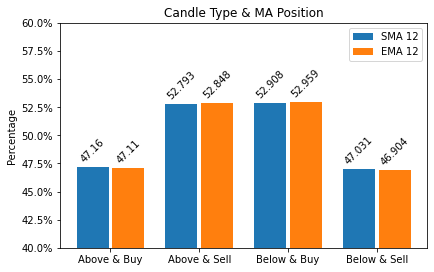

In [7]:
# Plot the results
x = np.arange(4)
width = 0.40

fig, ax = plt.subplots()
sma_rect = ax.bar(x - width/2, [round(x, 3) for x in ma_proba['SMA 12'].values()], width*0.9, label='SMA 12')
ema_rect = ax.bar(x + width/2, [round(x, 3) for x in ma_proba['EMA 12'].values()], width*0.9, label='EMA 12')

ax.set_ylabel('Percentage')
ax.set_title('Candle Type & MA Position')
ax.set_xticks(x, ma_proba['SMA 12'].keys())
ax.legend()

ax.bar_label(sma_rect, padding=3, rotation = 45)
ax.bar_label(ema_rect, padding=3, rotation = 45)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

fig.tight_layout()

plt.ylim([40, 60])
plt.show()

As we can see if the candle open will be above the value of the shifted MA it will have a nearly 53% chance of being a sell candle (viceversa if the candle open is below the MA). Now let's try to calculate these data for all the MA available.

In [8]:
ma_proba = {}

for ma in coin_df.columns[7:]:
    ma_proba[ma] = candle_position_freq(coin_df[ma])

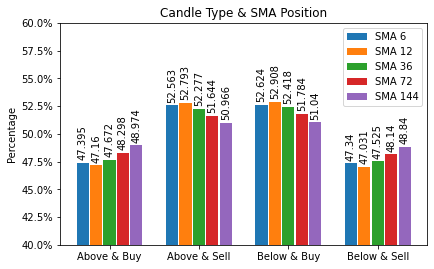

In [9]:
# Plot the results for SMAs
x = np.arange(4)
width = 0.15

fig, ax = plt.subplots()
sma_rect_1 = ax.bar(x - 4*width/2, [round(x, 3) for x in ma_proba['SMA 6'].values()], width*0.9, label='SMA 6')
sma_rect_2 = ax.bar(x - 2*width/2, [round(x, 3) for x in ma_proba['SMA 12'].values()], width*0.9, label='SMA 12')
sma_rect_3 = ax.bar(x, [round(x, 3) for x in ma_proba['SMA 36'].values()], width*0.9, label='SMA 36')
sma_rect_4 = ax.bar(x + 2*width/2, [round(x, 3) for x in ma_proba['SMA 72'].values()], width*0.9, label='SMA 72')
sma_rect_5 = ax.bar(x + 4*width/2, [round(x, 3) for x in ma_proba['SMA 144'].values()], width*0.9, label='SMA 144')

ax.set_ylabel('Percentage')
ax.set_title('Candle Type & SMA Position')
ax.set_xticks(x, ma_proba['SMA 12'].keys())
ax.legend(loc = 0)

ax.bar_label(sma_rect_1, padding=3, rotation = 90)
ax.bar_label(sma_rect_2, padding=3, rotation = 90)
ax.bar_label(sma_rect_3, padding=3, rotation = 90)
ax.bar_label(sma_rect_4, padding=3, rotation = 90)
ax.bar_label(sma_rect_5, padding=3, rotation = 90)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

fig.tight_layout()

plt.ylim([40, 60])
plt.show()

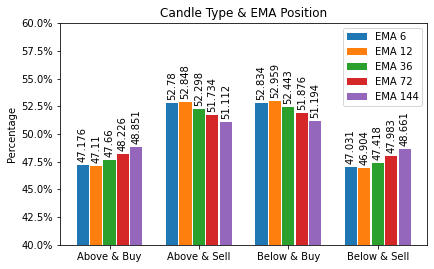

In [10]:
# Plot the results for EMAs
x = np.arange(4)
width = 0.15

fig, ax = plt.subplots()
ema_rect_1 = ax.bar(x - 4*width/2, [round(x, 3) for x in ma_proba['EMA 6'].values()], width*0.9, label='EMA 6')
ema_rect_2 = ax.bar(x - 2*width/2, [round(x, 3) for x in ma_proba['EMA 12'].values()], width*0.9, label='EMA 12')
ema_rect_3 = ax.bar(x, [round(x, 3) for x in ma_proba['EMA 36'].values()], width*0.9, label='EMA 36')
ema_rect_4 = ax.bar(x + 2*width/2, [round(x, 3) for x in ma_proba['EMA 72'].values()], width*0.9, label='EMA 72')
ema_rect_5 = ax.bar(x + 4*width/2, [round(x, 3) for x in ma_proba['EMA 144'].values()], width*0.9, label='EMA 144')

ax.set_ylabel('Percentage')
ax.set_title('Candle Type & EMA Position')
ax.set_xticks(x, ma_proba['SMA 12'].keys())
ax.legend(loc = 0)

ax.bar_label(ema_rect_1, padding=3, rotation = 90)
ax.bar_label(ema_rect_2, padding=3, rotation = 90)
ax.bar_label(ema_rect_3, padding=3, rotation = 90)
ax.bar_label(ema_rect_4, padding=3, rotation = 90)
ax.bar_label(ema_rect_5, padding=3, rotation = 90)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

fig.tight_layout()

plt.ylim([40, 60])
plt.show()

The results are very interesting! As the MA calculation period increases, the probability of having a buy candles in a bearish condition decreases (as well as for sell candles ina  bullish scenario). While, as the MA calculation period increases, the probability of having buy candles in a bullish scenario increases (as well as for sell candles in a bearish scenario). 
Thanks to this analysis we can think of creating a mean reverting strategy based on the data just obtained!

# First Strategy
At first we are going to create a dataframe with the signals of our strategy for each candle. Since the 12 EMA is the one that has a slightly better performance than the others, we will use it for our strategy. Let's analyze the current performance of the strategies and try to raise the winrate with further analysis.
#### Notes
For the Profit Factor Calculation we will assume to acquire 1 BTC in such a way as to reduce the number of calculations for evaluating the strategy.

In [11]:
# Start to define entries
strategy_df = coin_df[['open', 'high', 'low', 'close', 'candle', 'pnl', 'pnl %', 'EMA 12']]

buy_signal = coin_df['open'] < coin_df['EMA 12'].shift(1)
strategy_df.insert(strategy_df.shape[1], 'buy signal', np.where(buy_signal, 1, 0))

sell_signal = coin_df['open'] > coin_df['EMA 12'].shift(1)
strategy_df.insert(strategy_df.shape[1], 'sell signal', np.where(sell_signal, 1, 0))

0.5290147324772808 
 1.0290302889529692
0.5282895587116044 
 1.0319888511746198
Buy Winrate: 52.959%
Sell Winrate: 52.8476%
Combined Winrate: 52.9033%


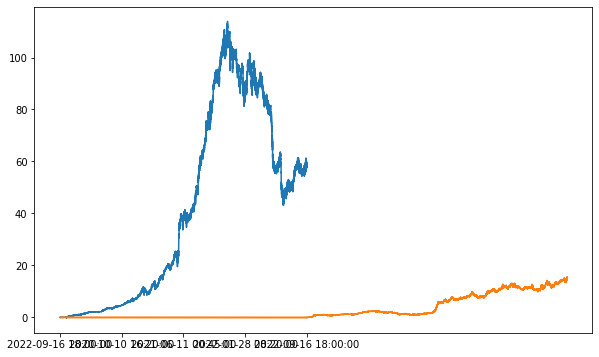

In [46]:
# Analyze winrate
buy_wr = (strategy_df['pnl'].loc[strategy_df['buy signal'] == 1] > 0).mean()
sell_wr = (strategy_df['pnl'].loc[strategy_df['sell signal'] == 1] < 0).mean()
combined_wr = (buy_wr + sell_wr)/2

bt_buy = strategy_df.loc[strategy_df['buy signal'] == 1]
bt_sell = strategy_df.loc[strategy_df['sell signal'] == 1]
#print(bt_buy)

sl = 0.01

perf_buy, wr_buy, al_buy, ap_buy, pf_buy = backtest(bt_buy['pnl %'].mask((bt_buy['low']/bt_buy['open'] - 1) < -sl, -sl),
                                bt_buy['pnl'].mask((bt_buy['low']/bt_buy['open'] - 1) < -sl, bt_buy['open']*-sl))

perf_sell, wr_sell, al_sell, ap_sell, pf_sell = backtest(bt_sell['pnl %'].mask((bt_sell['high']/bt_sell['open'] - 1) > sl, sl)*-1,
                                bt_sell['pnl'].mask((bt_sell['high']/bt_sell['open'] - 1) > sl, bt_sell['open']*sl)*-1)

plt.figure(figsize = (10, 6))
labels = [bt_buy.index[int(i)-1] for i in np.linspace(0, len(bt_buy.index), 5)]
pos = [int(x) for x in np.linspace(0, len(bt_buy.index), 5)]


plt.xticks(pos, labels)
plt.plot(perf_buy, label = "Strategy Performance Buy")
plt.plot(perf_sell, label = "Strategy Performance Sell")

print(wr_buy, "\n", pf_buy)     
print(wr_sell, "\n", pf_sell)

print(f"Buy Winrate: {buy_wr*100:.6}%")
print(f"Sell Winrate: {sell_wr*100:.6}%")
print(f"Combined Winrate: {combined_wr*100:.6}%")

In [13]:
# Analyze Profit Factor
buy_al = strategy_df['pnl'].loc[(strategy_df['buy signal'] == 1) & (strategy_df['pnl %'] < 0)].mean()
buy_ap = strategy_df['pnl'].loc[(strategy_df['buy signal'] == 1) & (strategy_df['pnl %'] > 0)].mean()

sell_al = strategy_df['pnl'].loc[(strategy_df['sell signal'] == 1) & (strategy_df['pnl %'] > 0)].mean()
sell_ap = strategy_df['pnl'].loc[(strategy_df['sell signal'] == 1) & (strategy_df['pnl %'] < 0)].mean()

buy_pf = (buy_wr*abs(buy_ap))/((1 - buy_wr)*abs(buy_al))
sell_pf = (sell_wr*abs(sell_ap))/((1 - sell_wr)*abs(sell_al))
combined_pf = np.mean([buy_pf, sell_pf])

print(f"Buy Profit Factor: {buy_pf:.6}")
print(f"Sell Profit Factor: {sell_pf:.6}")
print(f"Combined Profit Factor: {combined_pf:.6}")

Buy AProfit Factor: 1.02161
Sell Profit Factor: 1.02166
Combined Profit Factor: 1.02164


As we can seethe combined winrate is 52.9%, but a very low profit factor (barely more than 1). So we proceed with the extraction of other data to improve performance.

### Buy Strategy

We add the ATR indicator to obtain the relative distance data from the open

In [14]:
from ta.volatility import AverageTrueRange

#atr_72 = AverageTrueRange(strategy_df['high'], strategy_df['low'],
#                           strategy_df['close'], 72).average_true_range().replace(0, np.nan)
#ema_dis_atr_72 = (strategy_df['open'] - strategy_df['EMA 12'].shift(1))/atr_72.shift(1)
#
#strategy_df.insert(strategy_df.shape[1], 'Open - EMA 12 / ATR 72', ema_dis_atr_72)

atr_72 = AverageTrueRange(strategy_df['high'], strategy_df['low'],
                           strategy_df['close'], 72).average_true_range().replace(0, np.nan)
ema_dis_atr_72 = (strategy_df['open'] - strategy_df['EMA 12'].shift(1))/atr_72.shift(1)

strategy_df.insert(strategy_df.shape[1], 'RD Open - EMA 12', ema_dis_atr_72) # Relative Distance of Open from EMA 12

In [15]:
def relative_diff_prob(start, stop, step, _test_df, buy = True):

    ranges = []
    data = []
    prob = []

    for i in np.arange(start, stop, step):
        res = _test_df.loc[(_test_df['RD Open - EMA 12'] > i) & (_test_df['RD Open - EMA 12'] < i + step)]

        ranges.append(f"{round(i, 2)} / {round(i + step, 2)}")
        data.append(res)
        if buy: prob.append((res['pnl %'] > 0).mean())
        else: prob.append((res['pnl %'] < 0).mean())
    
    return ranges, data, prob

In [16]:
test_df = strategy_df.loc[(strategy_df['buy signal'] == 1)]
ranges_1, data_1, prob_1 = relative_diff_prob(-5, 0, 0.1, test_df)

C:\Users\axeli\AppData\Local\Temp\ipykernel_11320\3972478086.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ranges_1, rotation = 90)


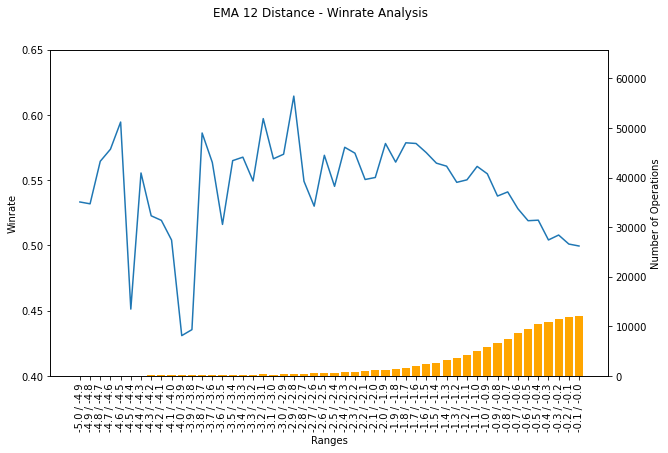

In [17]:
fig,ax = plt.subplots(figsize = (10, 6), facecolor = 'white')
fig.suptitle("EMA 12 Distance - Winrate Analysis")

ax.plot(ranges_1, prob_1)
ax.set_ylim((0.4, 0.65))
ax.set_xlabel("Ranges")
ax.set_ylabel("Winrate")
ax.set_xticklabels(ranges_1, rotation = 90)

ax2 = ax.twinx()
ax2.bar(ranges_1, [x.shape[0] for x in data_1], color = 'orange')
ax2.set_ylabel('Number of Operations')
ax2.set_ylim((0, sum([x.shape[0] for x in data_1])/2));

With this analysis we can see that when the relative distance is between -2.0 and -1.5 the probability of a green candle is greater than 55%. A good increase over the previous winrate! Now let's do another backtest to better check the performance.

In [18]:
def profit_factor(wr, al, ap):
    return abs((wr*ap)/((1 - wr)*al))

def backtest(pnl_perc, pnl):
        
    perf = np.cumprod(pnl_perc + 1) -1
    
    wr = (pnl_perc > 0).mean()
    al = pnl.loc[pnl < 0].mean()
    ap = pnl.loc[pnl > 0].mean()
    pf = profit_factor(wr, al, ap)
    
    return perf, wr, al, ap, pf

Winrate: 57.396%
Avg. Loss: -78.7909
Avg. Win: 65.0028
Profit Factor: 1.1115


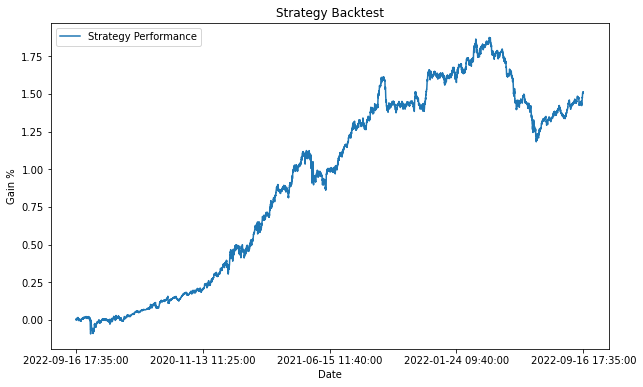

In [19]:
bt = strategy_df.loc[(strategy_df['buy signal'] == 1) &
                       (strategy_df['RD Open - EMA 12'] > -2.0) &
                       (strategy_df['RD Open - EMA 12'] < -1.5)]

perf, wr, al, ap, pf = backtest(bt['pnl %'], bt['pnl'])

plt.figure(figsize = (10, 6))
labels = [bt.index[int(i)-1] for i in np.linspace(0, len(bt.index), 5)]
pos = [int(x) for x in np.linspace(0, len(bt.index), 5)]

plt.xticks(pos, labels)
plt.plot(perf, label = "Strategy Performance")
plt.xlabel("Date")
plt.ylabel("Gain %")
plt.title("Strategy Backtest")
plt.legend(loc = 0);

print(f"Winrate: {wr*100:.5}%")
print(f"Avg. Loss: {al:.6}")
print(f"Avg. Win: {ap:.6}")
print(f"Profit Factor: {pf:.5}")

This is a pretty good improvement for our strategy, we have a winrate of 57.3% but an Average Loss greater than the Average Profit, we need to add a Stop Loss, so let's add it with an accurate analysis!

In [20]:
def sl_performance(_bt, sl_start, sl_stop, sl_step, buy = True):
    
    sl_list = []
    perf_list = []
    wr_list = []
    al_list = []
    ap_list = []
    pf_list = []
    
    for sl in np.arange(sl_start, sl_stop, sl_step):
        pnl_perc = _bt['pnl %'].mask((_bt['low']/_bt['open'] - 1) < -sl, -sl)
        pnl = _bt['pnl'].mask((_bt['low']/_bt['open'] - 1) < -sl, _bt['open']*-sl)

        if not buy:
            pnl_perc = _bt['pnl %'].mask((_bt['high']/_bt['open'] - 1) > sl, sl)*-1
            pnl = _bt['pnl'].mask((_bt['high']/_bt['open'] - 1) > sl, _bt['open']*sl)*-1
    
    
        perf, wr, al, ap, pf = backtest(pnl_perc, pnl)

        sl_list.append(round(sl, 5))
        perf_list.append(perf)
        wr_list.append(round(wr, 5))
        al_list.append(round(abs(al), 5))
        ap_list.append(round(abs(ap), 5))
        pf_list.append(round(pf, 5))
    
    return sl_list, perf_list,wr_list, al_list, ap_list, pf_list

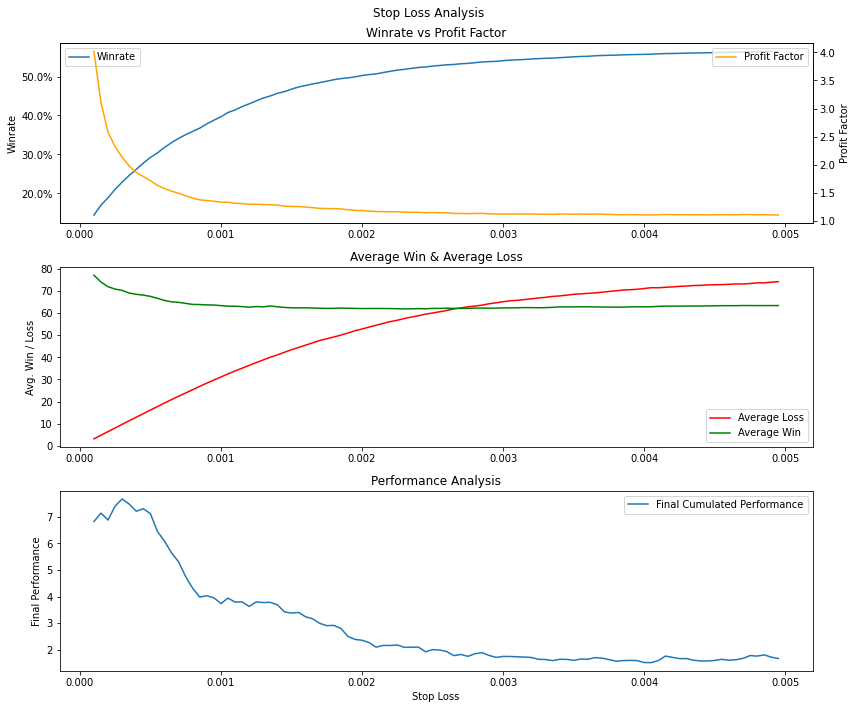

In [21]:
sl_list, perf_list, wr_list, al_list, ap_list, pf_list = sl_performance(bt, 0.0001, 0.005, 0.00005, True)

fig, axs = plt.subplots(3, figsize = (12, 10))
fig.suptitle("Stop Loss Analysis")

axs[0].set_title("Winrate vs Profit Factor")
axs[0].plot(sl_list, wr_list, label = "Winrate")
axs[0].set_ylabel('Winrate')
axs[0].legend(loc = 0)
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

ax2 = axs[0].twinx()
ax2.plot(sl_list, pf_list, color = 'orange', label = "Profit Factor")
ax2.set_ylabel('Profit Factor')
ax2.legend(loc = 0)

axs[1].set_title("Average Win & Average Loss")
axs[1].plot(sl_list, al_list, color = 'red', label = "Average Loss")
axs[1].plot(sl_list, ap_list, color = 'green', label = "Average Win")
axs[1].set_ylabel('Avg. Win / Loss')

axs[1].legend(loc = 0)

axs[2].set_title("Performance Analysis")
axs[2].plot(sl_list, [perf[-1] for perf in perf_list], label = "Final Cumulated Performance")
axs[2].set_ylabel('Final Performance')
axs[2].set_xlabel('Stop Loss')
axs[2].legend(loc = 0)

fig.tight_layout();

As we can see the introduction of a Stop Loss will reduce the Average Loss and Winrate but will increase the Profit Factor, so we need to identify which best Stop Loss guarantees a good performance.


Strategy Stop Loss 0.0005%
	Winrate: 29.205%
	Average Loss: -16.186
	Average Profit: 67.487
	Profit Factor: 1.72

Strategy Stop Loss 0.00065%
	Winrate: 33.018%
	Average Loss: -20.925
	Average Profit: 65.028
	Profit Factor: 1.5319

Strategy Stop Loss 0.001%
	Winrate: 39.677%
	Average Loss: -31.129
	Average Profit: 63.295
	Profit Factor: 1.3374

Strategy Stop Loss 0.0015%
	Winrate: 46.763%
	Average Loss: -43.439
	Average Profit: 62.342
	Profit Factor: 1.2606

Strategy Stop Loss 0.002%
	Winrate: 50.276%
	Average Loss: -52.763
	Average Profit: 61.987
	Profit Factor: 1.1879


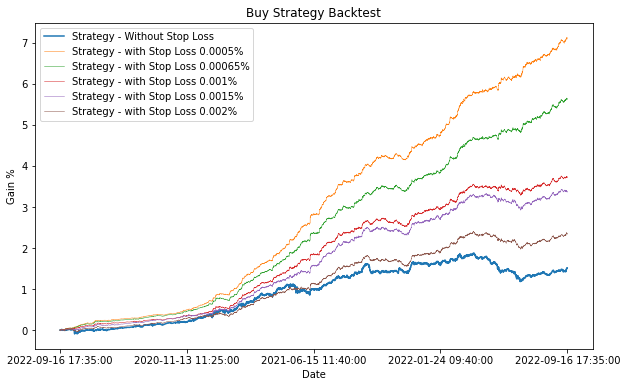

In [22]:
index = [sl_list.index(i) for i in [0.0005, 0.00065, 0.001, 0.0015, 0.002]]

plt.figure(figsize = (10, 6), facecolor = 'white')

labels = [bt.index[int(i)-1] for i in np.linspace(0, len(bt.index), 5)]
pos = [int(x) for x in np.linspace(0, len(bt.index), 5)]
plt.xticks(pos, labels)

plt.plot(np.cumprod(bt['pnl %'] + 1) - 1, label = "Strategy - Without Stop Loss")

for i in index:
    plt.plot(perf_list[i], label = f"Strategy - with Stop Loss {sl_list[i]}%", linewidth = 0.5)
    
    print(f"\nStrategy Stop Loss {sl_list[i]}%")
    print(f"\tWinrate: {wr_list[i]*100:.5}%")
    print(f"\tAverage Loss: -{al_list[i]:.5}")
    print(f"\tAverage Profit: {ap_list[i]:.5}")
    print(f"\tProfit Factor: {pf_list[i]:.5}")
    

plt.xlabel("Date")
plt.ylabel("Gain %")
plt.title("Buy Strategy Backtest")
plt.legend(loc = 0)

fig.tight_layout();

Perfect! With a Stop Loss between 0.1% and 0.05% we obtain a high Profit Factor and a fantastic performance! For our strategy we will use a Stop Loss of 0.065% with a Profit Factor slightly higher than 1.5 and we will see how our simulation will behave.

In [23]:
sl = 0.00065
cap = 10000

simulation = strategy_df.loc[(strategy_df['buy signal'] == 1) &
                       (strategy_df['RD Open - EMA 12'] > -2.0) &
                       (strategy_df['RD Open - EMA 12'] < -1.5)].iloc[:, : 4]

simulation['SL'] = np.round(simulation['open']*(1 - sl), 2)
simulation['PNL'] = (simulation['close'] - simulation['open']).mask(simulation['low'] < simulation['SL'],
                                                                    simulation['SL'] - simulation['open'])
simulation['PNL %'] = np.round(simulation['PNL']/simulation['open'], 8)
simulation['Simulation'] = np.cumprod(simulation['PNL %'] + 1) * cap

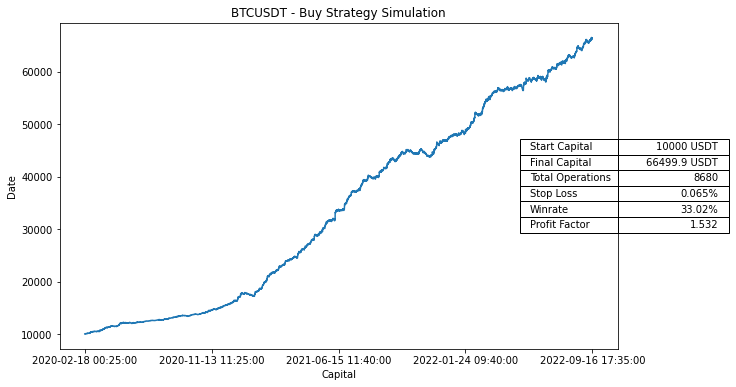

In [24]:
plt.figure(figsize = (10, 6), facecolor = 'white')

labels = [simulation.index[int(i)-1] for i in np.linspace(1, len(simulation.index), 5)]
pos = [int(x) for x in np.linspace(0, len(simulation.index), 5)]
plt.xticks(pos, labels)

plt.title("BTCUSDT - Buy Strategy Simulation")

plt.plot(simulation['Simulation'], label = "Simulation")
plt.xlabel('Capital')
plt.ylabel('Date')

wr = (simulation['PNL'] > 0).mean()
al = simulation['PNL'].loc[simulation['PNL'] < 0].mean()
ap = simulation['PNL'].loc[simulation['PNL'] > 0].mean()
pf = profit_factor(wr, al, ap)

cell_text = [[f"{cap} USDT"], [f"{round(simulation['Simulation'][-1], 2)} USDT"], [simulation.shape[0]],
            [f"{sl*100:2.5}%"], [f"{wr*100:2.4}%"], [f"{pf:.5}"]]
row_lab = ['Start Capital', 'Final Capital', 'Total Operations', 'Stop Loss', 'Winrate', 'Profit Factor']
t = plt.table(cell_text, rowLabels = row_lab, loc='right', colWidths = [0.2])
t.scale(1, 1.3)

fig.tight_layout();

#simulation.to_excel("BTCUSDT Strategy Buy.xlsx")

We find a very good strategy, now let's move on a Sell Strategy!

### Sell Strategy

In [25]:
test_df = strategy_df.loc[(strategy_df['sell signal'] == 1)]
ranges_1, data_1, prob_1 = relative_diff_prob(0, 5, 0.1, test_df, False)

C:\Users\axeli\AppData\Local\Temp\ipykernel_11320\4285768342.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ranges_1, rotation = 90)


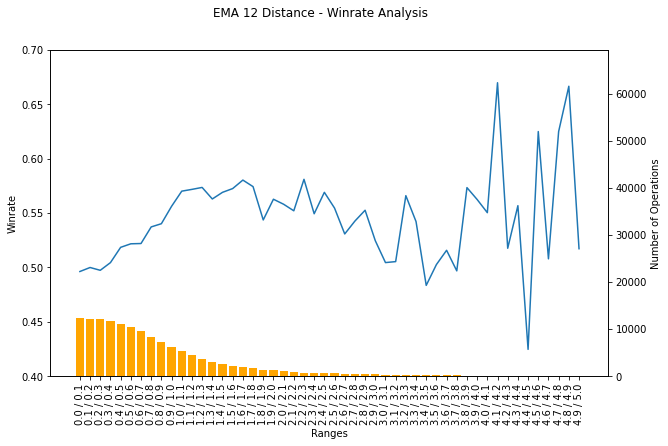

In [26]:
fig,ax = plt.subplots(figsize = (10, 6))
fig.suptitle("EMA 12 Distance - Winrate Analysis")

ax.plot(ranges_1, prob_1)
ax.set_ylim((0.4, 0.7))
ax.set_xlabel("Ranges")
ax.set_ylabel("Winrate")
ax.set_xticklabels(ranges_1, rotation = 90)

ax2 = ax.twinx()
ax2.bar(ranges_1, [x.shape[0] for x in data_1], color = 'orange')
ax2.set_ylabel('Number of Operations')
ax2.set_ylim((0, sum([x.shape[0] for x in data_1])/2));

Winrate: 57.128%
Avg. Loss: -55.5835
Avg. Win: 46.9071
Profit Factor: 1.1245


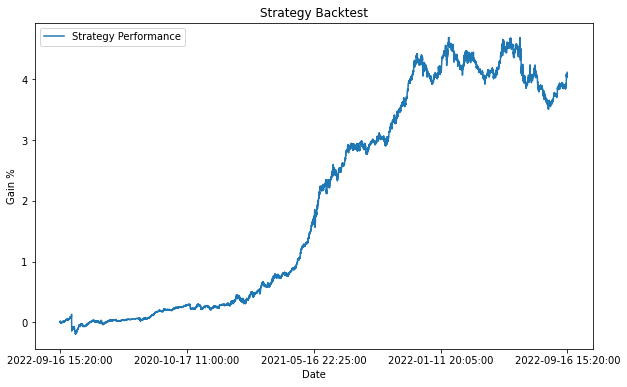

In [27]:
bt = strategy_df.loc[(strategy_df['sell signal'] == 1) &
                       (strategy_df['RD Open - EMA 12'] > 1.0) &
                       (strategy_df['RD Open - EMA 12'] < 1.8)]

perf, wr, al, ap, pf = backtest(bt['pnl %']*-1, bt['pnl']*-1)

plt.figure(figsize = (10, 6))
labels = [bt.index[int(i)-1] for i in np.linspace(0, len(bt.index), 5)]
pos = [int(x) for x in np.linspace(0, len(bt.index), 5)]

plt.xticks(pos, labels)
plt.plot(perf, label = "Strategy Performance")
plt.xlabel("Date")
plt.ylabel("Gain %")
plt.title("Strategy Backtest")
plt.legend(loc = 0);

print(f"Winrate: {wr*100:.5}%")
print(f"Avg. Loss: {al:.6}")
print(f"Avg. Win: {ap:.6}")
print(f"Profit Factor: {pf:.5}")

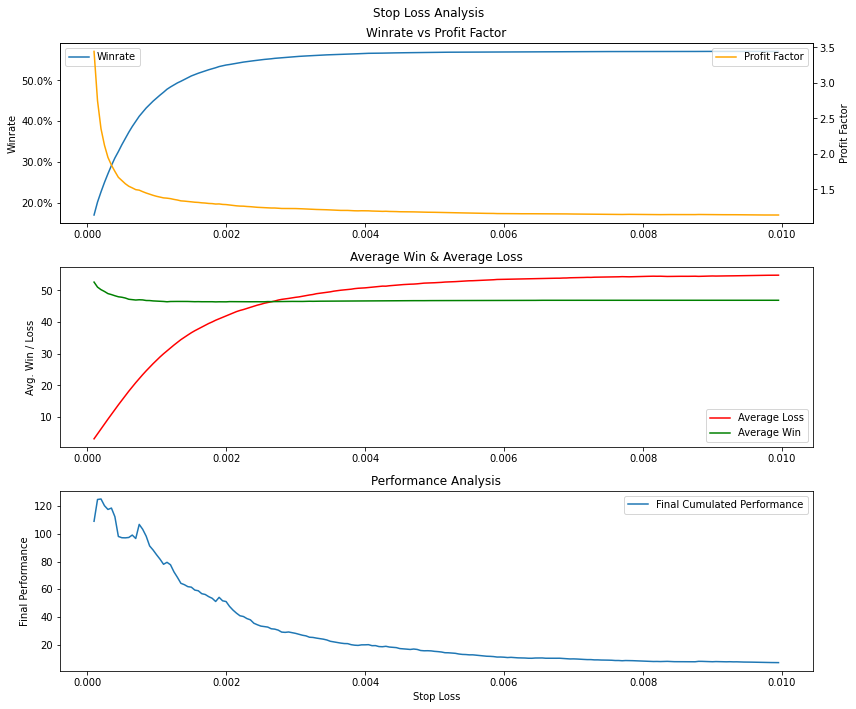

In [28]:
sl_list, perf_list, wr_list, al_list, ap_list, pf_list = sl_performance(bt, 0.0001, 0.01, 0.00005, False)

fig, axs = plt.subplots(3, figsize = (12, 10))
fig.suptitle("Stop Loss Analysis")

axs[0].set_title("Winrate vs Profit Factor")
axs[0].plot(sl_list, wr_list, label = "Winrate")
axs[0].set_ylabel('Winrate')
axs[0].legend(loc = 0)
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

ax2 = axs[0].twinx()
ax2.plot(sl_list, pf_list, color = 'orange', label = "Profit Factor")
ax2.set_ylabel('Profit Factor')
ax2.legend(loc = 0)

axs[1].set_title("Average Win & Average Loss")
axs[1].plot(sl_list, al_list, color = 'red', label = "Average Loss")
axs[1].plot(sl_list, ap_list, color = 'green', label = "Average Win")
axs[1].set_ylabel('Avg. Win / Loss')

axs[1].legend(loc = 0)

axs[2].set_title("Performance Analysis")
axs[2].plot(sl_list, [perf[-1] for perf in perf_list], label = "Final Cumulated Performance")
axs[2].set_ylabel('Final Performance')
axs[2].set_xlabel('Stop Loss')
axs[2].legend(loc = 0)

fig.tight_layout();


Strategy Stop Loss 0.0005%
	Winrate: 34.198%
	Average Loss: -15.303
	Average Profit: 47.833
	Profit Factor: 1.6245

Strategy Stop Loss 0.001%
	Winrate: 45.657%
	Average Loss: -27.939
	Average Profit: 46.624
	Profit Factor: 1.4021

Strategy Stop Loss 0.0015%
	Winrate: 51.08%
	Average Loss: -36.622
	Average Profit: 46.45
	Profit Factor: 1.3244

Strategy Stop Loss 0.002%
	Winrate: 53.758%
	Average Loss: -41.934
	Average Profit: 46.381
	Profit Factor: 1.2858

Strategy Stop Loss 0.005%
	Winrate: 56.873%
	Average Loss: -52.413
	Average Profit: 46.772
	Profit Factor: 1.1768


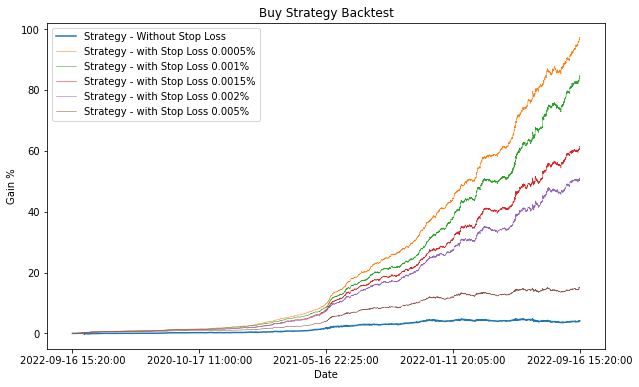

In [29]:
index = [sl_list.index(i) for i in [0.0005, 0.001, 0.0015, 0.002, 0.005]]

plt.figure(figsize = (10, 6), facecolor = 'white')

labels = [bt.index[int(i)-1] for i in np.linspace(0, len(bt.index), 5)]
pos = [int(x) for x in np.linspace(0, len(bt.index), 5)]
plt.xticks(pos, labels)

plt.plot(np.cumprod(bt['pnl %']*-1 + 1) - 1, label = "Strategy - Without Stop Loss")

for i in index:
    plt.plot(perf_list[i], label = f"Strategy - with Stop Loss {sl_list[i]}%", linewidth = 0.5)
    
    print(f"\nStrategy Stop Loss {sl_list[i]}%")
    print(f"\tWinrate: {wr_list[i]*100:.5}%")
    print(f"\tAverage Loss: -{al_list[i]:.5}")
    print(f"\tAverage Profit: {ap_list[i]:.5}")
    print(f"\tProfit Factor: {pf_list[i]:.5}")
    

plt.xlabel("Date")
plt.ylabel("Gain %")
plt.title("Buy Strategy Backtest")
plt.legend(loc = 0)

fig.tight_layout();

In [30]:
sl = 0.0005
cap = 10000

simulation = strategy_df.loc[(strategy_df['sell signal'] == 1) &
                       (strategy_df['RD Open - EMA 12'] > 1.0) &
                       (strategy_df['RD Open - EMA 12'] < 1.8)].iloc[:, : 4]

simulation['SL'] = np.round(simulation['open']*(1 + sl), 2)
simulation['PNL'] = ((simulation['close'] - simulation['open'])*-1).mask(simulation['high'] > simulation['SL'],
                                                                    (simulation['SL'] - simulation['open'])*-1)
simulation['PNL %'] = np.round(simulation['PNL']/simulation['open'], 8)
simulation['Simulation'] = np.round(np.cumprod(simulation['PNL %'] + 1) * cap, 2)

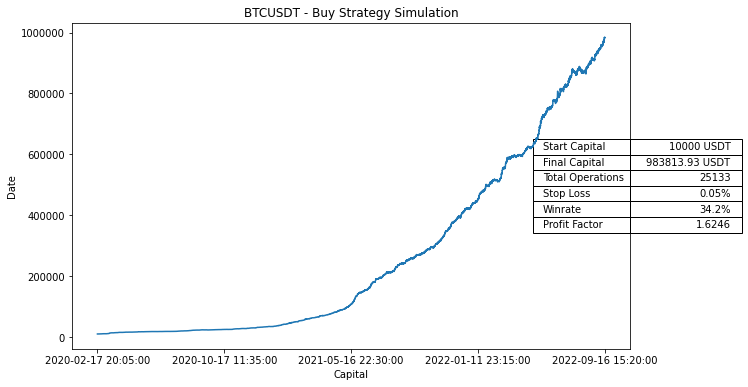

In [31]:
plt.figure(figsize = (10, 6), facecolor = 'white')

labels = [simulation.index[int(i)-1] for i in np.linspace(1, len(simulation.index), 5)]
pos = [int(x) for x in np.linspace(0, len(simulation.index), 5)]
plt.xticks(pos, labels)

plt.title("BTCUSDT - Buy Strategy Simulation")

plt.plot(simulation['Simulation'], label = "Simulation")
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Capital')
plt.ylabel('Date')

wr = (simulation['PNL'] > 0).mean()
al = simulation['PNL'].loc[simulation['PNL'] < 0].mean()
ap = simulation['PNL'].loc[simulation['PNL'] > 0].mean()
pf = profit_factor(wr, al, ap)

cell_text = [[f"{cap} USDT"], [f"{round(simulation['Simulation'][-1], 2)} USDT"], [simulation.shape[0]],
            [f"{sl*100:2.5}%"], [f"{wr*100:2.4}%"], [f"{pf:.5}"]]
row_lab = ['Start Capital', 'Final Capital', 'Total Operations', 'Stop Loss', 'Winrate', 'Profit Factor']
t = plt.table(cell_text, rowLabels = row_lab, loc='right', colWidths = [0.2])
t.scale(1, 1.3)

fig.tight_layout();

#simulation.to_excel("BTCUSDT Strategy Sell.xlsx")
#simulation

## Combined Strategy

In [32]:
sl = 0.0005
cap = 10000

buy_cond = (strategy_df['buy signal'] == 1) & (strategy_df['RD Open - EMA 12'] > -2.0) & (strategy_df['RD Open - EMA 12'] < -1.5)
sell_cond = (strategy_df['sell signal'] == 1) & (strategy_df['RD Open - EMA 12'] > 1.0) & (strategy_df['RD Open - EMA 12'] < 1.8)

simulation_buy = strategy_df.loc[buy_cond].iloc[:, : 4]
simulation_buy['signal'] = 'Buy'
simulation_buy['SL'] = np.round(simulation_buy['open']*(1 - sl), 2)
simulation_buy['PNL'] = ((simulation_buy['close'] - simulation_buy['open'])).mask(simulation_buy['low'] < simulation_buy['SL'],
                                                                    (simulation_buy['SL'] - simulation_buy['open']))
simulation_buy['PNL %'] = np.round(simulation_buy['PNL']/simulation_buy['open'], 8)

simulation_sell = strategy_df.loc[sell_cond].iloc[:, : 4]
simulation_sell['signal'] = 'Sell'
simulation_sell['SL'] = np.round(simulation_sell['open']*(1 + sl), 2)
simulation_sell['PNL'] = ((simulation_sell['close'] - simulation_sell['open'])*-1).mask(simulation_sell['high'] > simulation_sell['SL'],
                                                                    (simulation_sell['SL'] - simulation_sell['open'])*-1)
simulation_sell['PNL %'] = np.round(simulation_sell['PNL']/simulation_sell['open'], 8)

#simulation['Simulation'] = np.round(np.cumprod(simulation['PNL %'] + 1) * cap, 2)
simulation = pd.concat([simulation_buy, simulation_sell], sort=False).sort_index()
simulation['Simulation'] = np.round(np.cumprod(simulation['PNL %'] + 1) * cap, 2)

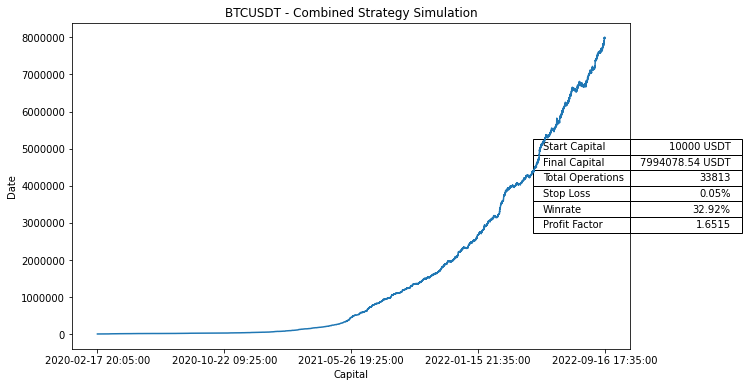

In [33]:
plt.figure(figsize = (10, 6), facecolor = 'white')

labels = [simulation.index[int(i)-1] for i in np.linspace(1, len(simulation.index), 5)]
pos = [int(x) for x in np.linspace(0, len(simulation.index), 5)]
plt.xticks(pos, labels)

plt.title("BTCUSDT - Combined Strategy Simulation")

plt.plot(simulation['Simulation'], label = "Simulation")
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Capital')
plt.ylabel('Date')

wr = (simulation['PNL'] > 0).mean()
al = simulation['PNL'].loc[simulation['PNL'] < 0].mean()
ap = simulation['PNL'].loc[simulation['PNL'] > 0].mean()
pf = profit_factor(wr, al, ap)

cell_text = [[f"{cap} USDT"], [f"{round(simulation['Simulation'][-1], 2)} USDT"], [simulation.shape[0]],
            [f"{sl*100:2.5}%"], [f"{wr*100:2.4}%"], [f"{pf:.5}"]]
row_lab = ['Start Capital', 'Final Capital', 'Total Operations', 'Stop Loss', 'Winrate', 'Profit Factor']
t = plt.table(cell_text, rowLabels = row_lab, loc='right', colWidths = [0.2])
t.scale(1, 1.3)

fig.tight_layout();

In [34]:
# Create a Function to get all the possible combination of elements in a list
from itertools import combinations

def get_combinations(sample_list, n):
    return list(combinations(sample_list, n))

# Example
print(get_combinations(coin_df.columns[7:], 2))

[('SMA 6', 'SMA 12'), ('SMA 6', 'SMA 36'), ('SMA 6', 'SMA 72'), ('SMA 6', 'SMA 144'), ('SMA 6', 'EMA 6'), ('SMA 6', 'EMA 12'), ('SMA 6', 'EMA 36'), ('SMA 6', 'EMA 72'), ('SMA 6', 'EMA 144'), ('SMA 12', 'SMA 36'), ('SMA 12', 'SMA 72'), ('SMA 12', 'SMA 144'), ('SMA 12', 'EMA 6'), ('SMA 12', 'EMA 12'), ('SMA 12', 'EMA 36'), ('SMA 12', 'EMA 72'), ('SMA 12', 'EMA 144'), ('SMA 36', 'SMA 72'), ('SMA 36', 'SMA 144'), ('SMA 36', 'EMA 6'), ('SMA 36', 'EMA 12'), ('SMA 36', 'EMA 36'), ('SMA 36', 'EMA 72'), ('SMA 36', 'EMA 144'), ('SMA 72', 'SMA 144'), ('SMA 72', 'EMA 6'), ('SMA 72', 'EMA 12'), ('SMA 72', 'EMA 36'), ('SMA 72', 'EMA 72'), ('SMA 72', 'EMA 144'), ('SMA 144', 'EMA 6'), ('SMA 144', 'EMA 12'), ('SMA 144', 'EMA 36'), ('SMA 144', 'EMA 72'), ('SMA 144', 'EMA 144'), ('EMA 6', 'EMA 12'), ('EMA 6', 'EMA 36'), ('EMA 6', 'EMA 72'), ('EMA 6', 'EMA 144'), ('EMA 12', 'EMA 36'), ('EMA 12', 'EMA 72'), ('EMA 12', 'EMA 144'), ('EMA 36', 'EMA 72'), ('EMA 36', 'EMA 144'), ('EMA 72', 'EMA 144')]
